In [17]:
# Importing the necessary libraries
import tensorflow as tf
import json
import os
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [18]:
# Necessary Variables
vocab_size = 3000
embedding_dim = 32
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [19]:
dataList = []
sentences = []
labels = []
# Stopwords should be removed or excluded from the given text so that more
# focus can be given to those words which define the meaning of the text.
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    for word in stopwords: #Remove stop words in sentence
      token = " " + word + " "
      sentence = sentence.replace(token, " ")
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")

import pandas as pd
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])
df= pd.concat([sen, nonsen], axis=0)
df=df.sample(frac=1).reset_index(drop=True)
df_sen=df[df['labels']==1]
df_non=df[df['labels']==0]
df_non_downsampled = df_non.sample(10000)
df_sen_downsampled=df_sen.sample(10000)
df_balanced = pd.concat([df_non_downsampled, df_sen_downsampled])

# Splitting into features (X) and labels (y)
X = df_balanced['sentences'].values
y = df_balanced['labels'].values


training_sentences, validation_sentences, training_labels, validation_labels= train_test_split(X,y,test_size=0.2,stratify=y)

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences)
print("Validation Dataset Size: ", len(validation_sentences))
print("Sample Validation Data:", validation_sentences)

Training Dataset Size:  16000
Sample Training Data: ['username:marie-luce, password:millos, email:marie-luce@aim.com, phone no:3268006471'
 'number plate:tn 10 5070'
 "It 1935. Before returning England become new Foreign Secretary, writer, soldier, diplomat Robert Conway (Ronald Colman) one last task China: rescue 90 white Westerners city Baskul. He flies last evacuees, just ahead armed revolutionaries.\nUnbeknownst passengers, pilot replaced aircraft hijacked. It eventually runs fuel crashes deep Himalayan Mountains, killing abductor. The group rescued Chang (H.B. Warner) men taken Shangri-La, idyllic valley sheltered bitter cold. The contented inhabitants led mysterious High Lama (Sam Jaffe).\nInitially anxious return civilization, newcomers grow love Shangri-La, including paleontologist Alexander Lovett (Edward Everett Horton), swindler Henry Barnard (Thomas Mitchell), bitter, terminally-ill Gloria Stone (Isabel Jewell), miraculously seems recovering. Conway particularly enchanted, 

In [20]:
# Tokenizer takes the num_words (here vocab_size = 3000) maximum occuring unique words from the dataset.
# Anything out of these words will be treated as Out of Vocabulary(<oov>)
# It strips the punctutations and removes upper-case letters.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Apply the tokenizer on training sentences and generate the word index
# Eg: word_index["the"] = 1; word_index["cat"] = 2; etc.
tokenizer.fit_on_texts(training_sentences)

# Save the word index (Used for deploying in web application)
word_index = tokenizer.word_index
print("Size of word index:", len(word_index))

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

# Transforms each word in sentences to a sequence of integers based on the word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# To feed the text into neural network - sentences must be of the same length. Hence we'll be using padding.
# If the sentences are smaller than the maxlen, then we'll pad (Here, we are using post padding)
# If the sentences are larger than the maxlen, then we'll truncate (Here, we are using post truncation)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

# Apply the same for validation data
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Size of word index: 91339
Saving the word index as JSON


In [21]:
# Convert to Numpy arrays, so as to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

In [38]:
from tensorflow.keras import Model
#from tensorflow.keras.layers import Embedding, Dense, CuDNNLSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM


class TextRNN(Model):
    def __init__(self,
                 maxlen,
                 max_features,
                 embedding_dims,
                 class_num=1,
                 last_activation='sigmoid'):
        super(TextRNN, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)
        self.rnn = LSTM(64)  # LSTM or GRU
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
        if len(inputs.shape) != 2:
            raise ValueError('The rank of inputs of TextRNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.shape[1] != self.maxlen:
            raise ValueError('The maxlen of inputs of TextRNN must be %d, but now is %d' % (self.maxlen, inputs.get_shape()[1]))
        embedding = self.embedding(inputs)
        x = self.rnn(embedding)
        output = self.classifier(x)
        return output

Build model...
Epoch 1/5
500/500 [==============================] - 21s 37ms/step - loss: 0.0496 - accuracy: 0.9891 - val_loss: 0.0054 - val_accuracy: 0.9995
Epoch 2/5
500/500 [==============================] - 18s 35ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.0023 - val_accuracy: 0.9998
Epoch 3/5
500/500 [==============================] - 19s 37ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 0.9998
Epoch 4/5
500/500 [==============================] - 18s 36ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 2.2592e-04 - val_accuracy: 1.0000
Epoch 5/5
500/500 [==============================] - 19s 38ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 5.5169e-04 - val_accuracy: 1.0000


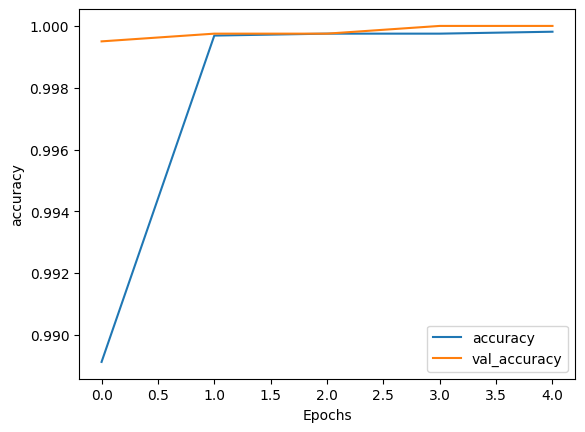

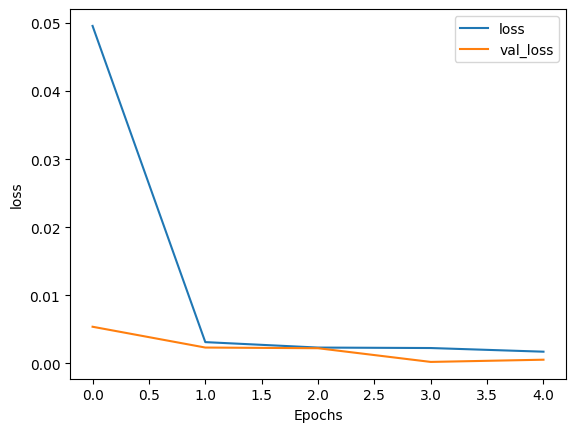

Confusion Matrix
125/125 [==============================] - 1s 7ms/step
Threshold [0.4994855]
Accuracy for Test Data =  100.0
Accuracy Score: 100.0
1/1 [==============================] - 1s 577ms/step
0.99893653
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive - Sr No
0.9989365
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive -  Blood Bank Name
0.99893653
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive -  State
0.99893653
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive -  District
0.99893653
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive -  City
0.99893653
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive -  Address
0.99893653
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive - Pincode
0.99893653
Threshold corresponding to 0.9 sensitivity rate: 0.998936116695404
Sensitive -  Contact No
0.998

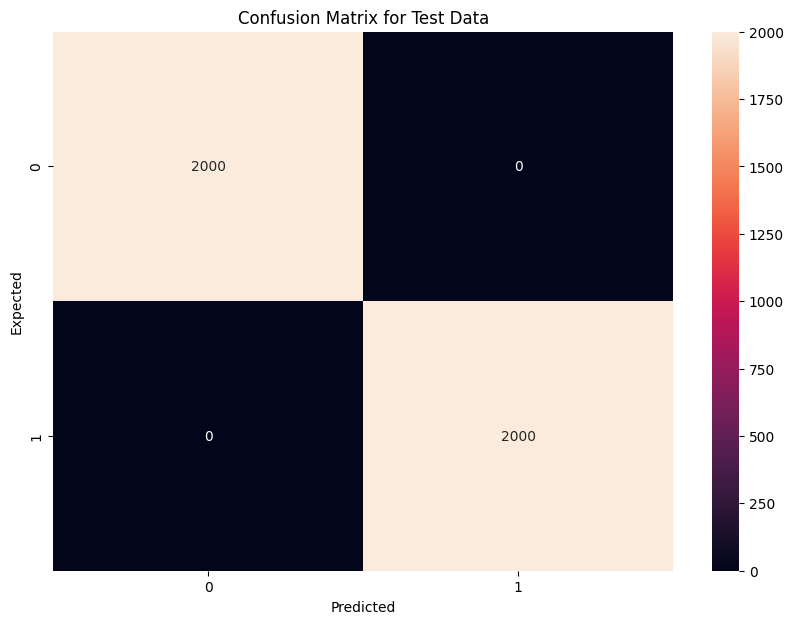

In [39]:
#find embedding dimension
max_features = len(tokenizer.word_index) + 1
embedding_dims = 32
model = TextRNN(maxlen=max_length,
                max_features=max_features,
                embedding_dims=embedding_dims)
print('Build model...')
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
#Use call function from TextRNN class and give inputs as training_padded
model.call(training_padded)
# Display the summary of the model
#model.summary()
num_epochs = 5
# model.fit - Train the model for a fixed number of epochs
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(
                        validation_padded, 
                        validation_labels), 
                    verbose=1,)
              # callbacks=[callbacks])
import matplotlib.pyplot as plt
# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

import seaborn
import pandas as pd
print('Confusion Matrix')
y_predicted = model.predict(validation_padded)
print("Threshold",(min(y_predicted)+max(y_predicted))/2)
y_predicted_labels = y_predicted > 0.5
#print(y_predicted_labels)
size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

cm = tf.math.confusion_matrix(validation_labels,y_predicted_labels)
cm_np = cm.numpy()
conf_acc = ((cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np)) * 100
print("Accuracy for Test Data = ", conf_acc)
plt.figure(figsize = (10,7))
seaborn.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix for Test Data")
plt.xlabel('Predicted')
plt.ylabel('Expected')

from sklearn.metrics import classification_report,accuracy_score
report = classification_report(validation_labels,y_predicted_labels)
#print("Classification Report:\n", report)
print("Accuracy Score:", accuracy_score(validation_labels,y_predicted_labels)*100)

#decrese the accuracy from 100 to 99 or 98
#add more data to the dataset
#increase the number of epochs
#increase the number of layers
#increase the number of nodes in each layer

# Sample examples
sentence = ['Sr No', ' Blood Bank Name', ' State', ' District', ' City', ' Address',             
       'Pincode', ' Contact No', 'phone', ' Helpline', ' Fax', ' Email',                 
       ' Website', ' Nodal Officer ', ' Contact Nodal Officer',                   
       ' Mobile Nodal Officer', ' Email Nodal Officer',                              
       ' Qualification Nodal Officer', ' Category',                                       
       ' Blood Component Available', ' Apheresis', ' Service Time',                             
       ' License #', ' Date License Obtained', ' Date of Renewal', ' Latitude',                   
       ' Longitude']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  from sklearn.metrics import roc_curve

  # Assuming `y_test` are your true labels and `y_pred` are your model's predictions
  fpr, tpr, thresholds = roc_curve(validation_labels, y_predicted)

  Sensitivity = tpr 
  sensitivity_rate = 0.9

  # Find threshold closest to the given sensitivity rate
  idx = np.abs(tpr - sensitivity_rate).argmin()
  threshold = thresholds[idx]

  print(f"Threshold corresponding to {sensitivity_rate} sensitivity rate: {threshold}")
  if predictions[i][0]>threshold:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

In [32]:
# Sample examples
sentence = ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
predictions = model.predict(padded)
for i in range(len(predictions)):
  print(predictions[i][0])
  from sklearn.metrics import roc_curve

  # Assuming `y_test` are your true labels and `y_pred` are your model's predictions
  fpr, tpr, thresholds = roc_curve(validation_labels, y_predicted)

  Sensitivity = tpr 
  sensitivity_rate = 0.9

  # Find threshold closest to the given sensitivity rate
  idx = np.abs(tpr - sensitivity_rate).argmin()
  threshold = thresholds[idx]

  print(f"Threshold corresponding to {sensitivity_rate} sensitivity rate: {threshold}")
  if predictions[i][0]>threshold:
    print("Sensitive - "+ sentence[i])
  else:
    print("Non-Sensitive - " + sentence[i] )

1/1 [==============================] - 0s 38ms/step
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Name
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Age
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Gender
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Blood Type
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Medical Condition
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Date of Admission
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Doctor
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Hospital
0.9998292
Threshold corresponding to 0.9 sensitivity rate: 0.999829113483429
Sensitive - Insurance Provider
0.9998292
Threshold corresponding to 0.9 sensitiv